# Predict The Price Of Books

This notebook solution made 22th place of 5070 submissions with final result **0.78908**.

>The so-called paradoxes of an author, to which a reader takes exception, often exist not in the author's book at all, but rather in the reader's head.  
> --- Friedrich Nietzsche  

Books are open doors to the unimagined worlds which is unique to every person. It is more than just a hobby for many. There are many among us who prefer to spend more time with books than anything else. Here we explore a big database of books. Books of different genres, from thousands of authors.  

In this challenge, participants are required to use the dataset to build a Machine Learning model to predict the price of books based on a given set of features.  

**Size of training set:** 6237 records \
**Size of test set:** 1560 records  

**FEATURES:**      
    - Title: The title of the book  
    - Author: The author(s) of the book.  
    - Edition: The edition of the book eg (Paperback,– Import, 26 Apr 2018)  
    - Reviews: The customer reviews about the book  
    - Ratings: The customer ratings of the book  
    - Synopsis: The synopsis of the book  
    - Genre: The genre the book belongs to  
    - BookCategory: The department the book is usually available at.  
    - Price: The price of the book (Target variable)

Metric evaluation  
$$
1 - \sqrt{\sum_{i=1}^n(\log_{10}(y_{pred} +1) - \log_{10}(y_{true} +1))^2 \over n}
$$

## Importing Requred libraries and modules

In [1]:
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import warnings
from collections import Counter
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.svm import SVR
from tqdm.notebook import tqdm


sns.set(rc={'figure.figsize':(14, 8)}, palette='Set2', font_scale=1.25)
tqdm.pandas()
#warnings.filterwarnings('ignore')

## Loading and exploring data

In [2]:
data_train = pd.read_excel('Data_Train.xlsx')
data_test = pd.read_excel('Data_Test.xlsx')
sample_submission = pd.read_excel('Sample_Submission.xlsx')

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6237 non-null   object 
 1   Author        6237 non-null   object 
 2   Edition       6237 non-null   object 
 3   Reviews       6237 non-null   object 
 4   Ratings       6237 non-null   object 
 5   Synopsis      6237 non-null   object 
 6   Genre         6237 non-null   object 
 7   BookCategory  6237 non-null   object 
 8   Price         6237 non-null   float64
dtypes: float64(1), object(8)
memory usage: 438.7+ KB


In [4]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         1560 non-null   object
 1   Author        1560 non-null   object
 2   Edition       1560 non-null   object
 3   Reviews       1560 non-null   object
 4   Ratings       1560 non-null   object
 5   Synopsis      1560 non-null   object
 6   Genre         1560 non-null   object
 7   BookCategory  1560 non-null   object
dtypes: object(8)
memory usage: 97.6+ KB


In [5]:
data_train.sample(5)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
6161,Bhagat Singh - The Eternal Rebel,Malwinderjit Singh Waraich,"Paperback,– 2014",4.8 out of 5 stars,9 customer reviews,Bhagat Singh the eternal rebel.,Biographies & Autobiographies (Books),"Biographies, Diaries & True Accounts",225.0
4459,Plays: Ivanov/The Seagull/Uncle Vanya/Three Si...,Anton Chekhov,"Paperback,– 25 Jul 2002",5.0 out of 5 stars,3 customer reviews,Plays: Ivanov/The Seagull/Uncle Vanya/Three Si...,Theater,"Arts, Film & Photography",118.0
878,Celtic Empire (The Dirk Pitt Adventures),"Clive, Cussler, Dirk Cussler","Paperback,– 2019",3.5 out of 5 stars,2 customer reviews,An ancient mystery becomes an all-too-real mod...,Action & Adventure (Books),Action & Adventure,435.0
4035,The adventures of Tintin: King Ottokar's Sceptre,Herge,"Paperback,– 1 Jan 2013",4.7 out of 5 stars,37 customer reviews,Tintin is drawn into a nail-biting adventure w...,Comics & Mangas (Books),Comics & Mangas,409.0
980,They Do It with Mirrors (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.3 out of 5 stars,13 customer reviews,A man is shot at in a juvenile reform home – b...,"Crime, Thriller & Mystery (Books)","Crime, Thriller & Mystery",224.0


In [6]:
data_test.sample(5)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
1215,Publish and Be Damned – Censorship and Intoler...,Rajeev Dhavan,"Hardcover,– Import, 10 Jul 2019",4.0 out of 5 stars,1 customer review,The essays collected in this volume explore th...,Civil Rights,Politics
1391,The Country of First Boys: And Other Essays,Amartya Sen,"Hardcover,– 11 Aug 2015",4.1 out of 5 stars,23 customer reviews,"How do deprivations related to class, caste an...",Social Welfare & Social Services (Books),Politics
25,A Dictionary of Business and Management (Oxfor...,"0, Jonathan Law","Paperback,– 11 Apr 2016",4.5 out of 5 stars,2 customer reviews,The new edition of this established bestsellin...,Business Communication,"Language, Linguistics & Writing"
12,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,"Paperback,– 29 Apr 2003",4.2 out of 5 stars,39 customer reviews,"Original, experimental, and unparalleled in th...",Short Stories (Books),Action & Adventure
1451,Daytripper,"Gabriel Ba, Fabio Moon","Paperback,– 8 Feb 2011",4.5 out of 5 stars,12 customer reviews,The acclaimed Daytripper follows Bras de Olivi...,"Arts History, Theory & Criticism (Books)",Humour


### Title

In [7]:
data_train['Title']

0                     The Prisoner's Gold (The Hunters 3)
1                      Guru Dutt: A Tragedy in Three Acts
2                            Leviathan (Penguin Classics)
3                      A Pocket Full of Rye (Miss Marple)
4              LIFE 70 Years of Extraordinary Photography
                              ...                        
6232    Humans: A Brief History of How We F*cked It Al...
6233                                          The Chemist
6234    The Duke And I: Number 1 in series (Bridgerton...
6235                         Frostfire (Kanin Chronicles)
6236                          The First Order (Sam Capra)
Name: Title, Length: 6237, dtype: object

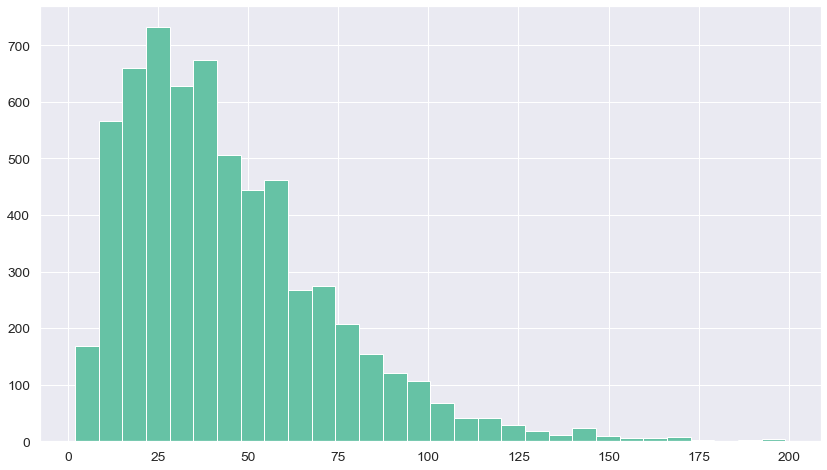

In [8]:
data_train['Title'].apply(len).hist(bins=30);

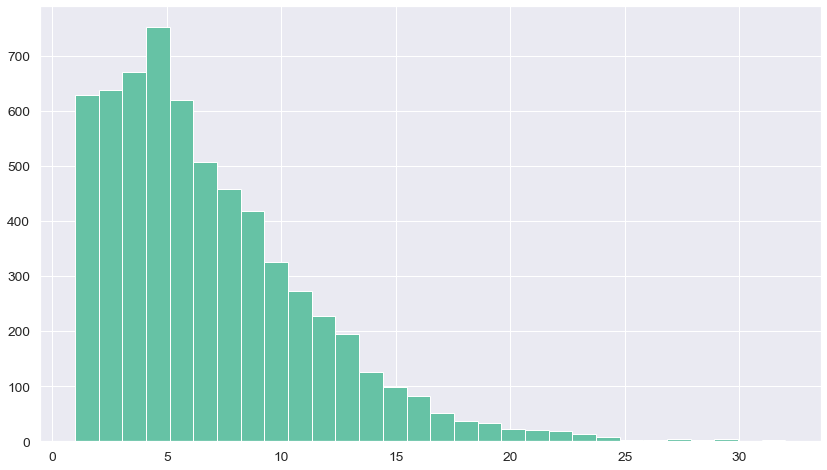

In [9]:
data_train['Title'].apply(lambda x: len(x.split())).hist(bins=30);

There are bookы with a length of more than 100 characters and longer than 200 words.

We can also get additional information from titles by tfidf method.

### Author

In [10]:
data_train['Author'].value_counts()

Agatha Christie      69
Ladybird             49
DK                   48
Albert Uderzo        34
Herge                34
                     ..
Bachi J. Karkaria     1
Tim Wu                1
Shruti                1
E F Schumacher        1
Stephenie Meyer       1
Name: Author, Length: 3679, dtype: int64

3679 unique Author names in train set

In [11]:
authors_rate = Counter(data_train['Author'])

In [12]:
authors_rate.update(data_test['Author'])

In [13]:
authors_rate.most_common()[:10]

[('Agatha Christie', 87),
 ('Ladybird', 63),
 ('DK', 61),
 ('Albert Uderzo', 48),
 ('Herge', 40),
 ('Nora Roberts', 40),
 ('James Patterson', 39),
 ('Bill Watterson', 36),
 ('John Grisham', 34),
 ('Sidney Sheldon', 33)]

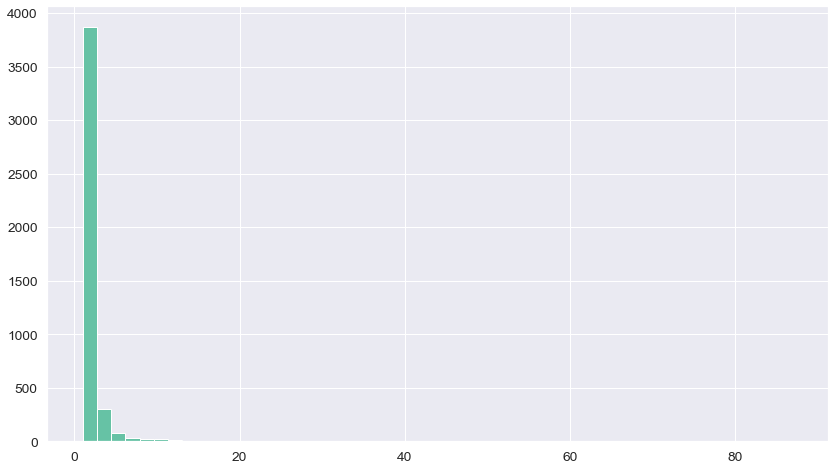

In [14]:
pd.Series(authors_rate.values()).hist(bins=50);

There some authors with many books. But mostly not many.

### Edition

In [15]:
data_train['Edition'].value_counts()

Paperback,– 5 Oct 2017            48
Paperback,– 2016                  46
Paperback,– 2017                  36
Paperback,– 2013                  31
Paperback,– 2019                  30
                                  ..
Paperback,– 4 Mar 2013             1
Hardcover,– Import, 6 Oct 2017     1
Hardcover,– 24 Oct 2018            1
Paperback,– 16 Aug 2018            1
Paperback,– 15 Jan 2015            1
Name: Edition, Length: 3370, dtype: int64

As we can see Edition column format may not consist some information. Some consists day and month.

Let's discver first words of Edition cells

In [16]:
data_train['Edition'].apply(lambda x: x.split()[0]).value_counts()

Paperback,–              5193
Hardcover,–               823
Mass                      155
Sheet                      24
Flexibound,–               15
Cards,–                     8
Spiral-bound,–              4
Tankobon                    3
Loose                       2
Library                     1
(French),Paperback,–        1
Leather                     1
(German),Paperback,–        1
Board                       1
Product                     1
(Kannada),Paperback,–       1
Perfect                     1
Plastic                     1
(Spanish),Paperback,–       1
Name: Edition, dtype: int64

In [17]:
len(data_train[~data_train['Edition'].str.contains('\d{4}')])

21

There are also some cells which not contains a year information.

Let's discover unique words in Edition column

In [18]:
count = Counter()
for item in data_train['Edition'].apply(str.split):
    count.update(filter(lambda x: not x.isdigit(), item))

In [19]:
count.most_common()

[('Paperback,–', 5349),
 ('Hardcover,–', 823),
 ('Oct', 639),
 ('Import,', 616),
 ('Sep', 543),
 ('May', 537),
 ('Jan', 514),
 ('Jun', 501),
 ('Nov', 487),
 ('Apr', 470),
 ('Jul', 457),
 ('Mar', 455),
 ('Aug', 446),
 ('Feb', 410),
 ('Dec', 408),
 ('Mass', 155),
 ('Market', 155),
 ('Illustrated,', 53),
 ('Edition,', 43),
 ('Sheet', 24),
 ('music,–', 24),
 ('Special', 19),
 ('Unabridged,', 18),
 ('Box', 16),
 ('Flexibound,–', 15),
 ('Abridged,', 15),
 ('Student', 14),
 ('Print,', 12),
 ('set,', 11),
 ('Large', 11),
 ('International', 10),
 ('Audiobook,', 10),
 ('Import', 9),
 ('Cards,–', 8),
 ('Deckle', 7),
 ('Edge,', 7),
 ('set', 5),
 ('Spiral-bound,–', 4),
 ('Tankobon', 3),
 ('Softcover,–', 3),
 ('Facsimile,', 3),
 ('Loose', 2),
 ('Leaf,–', 2),
 ('Print', 2),
 ('Plastic', 1),
 ('Comb,–', 1),
 ('DVD,', 1),
 ('NTSC', 1),
 ('Bargain', 1),
 ('Price,', 1),
 ('Perfect', 1),
 ('Facsimile', 1),
 ('Edition', 1),
 ('Board', 1),
 ('book,–', 1),
 ('Unabridged', 1),
 ('(Kannada),Paperback,–', 1),
 

We can use some most common words as additional features

### Reviews

Distribution of reviews

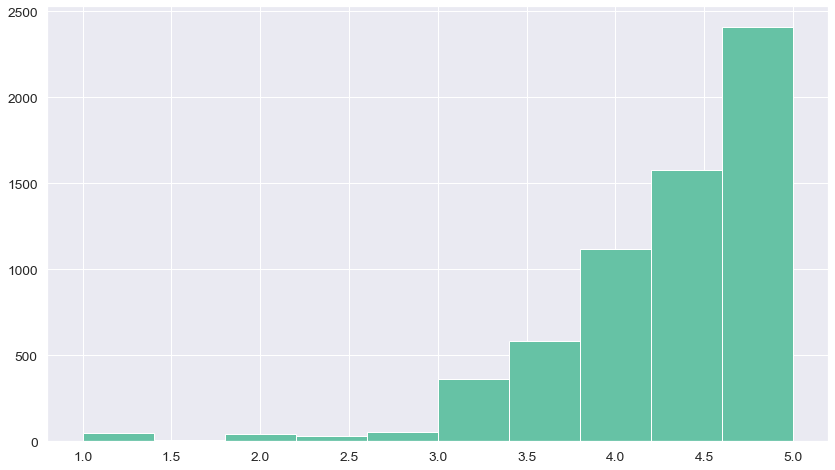

In [20]:
data_train['Reviews'].apply(lambda x: float(x.split()[0])).hist();

### Ratings

In [21]:
data_train['Ratings']

0        8 customer reviews
1       14 customer reviews
2        6 customer reviews
3       13 customer reviews
4         1 customer review
               ...         
6232     2 customer reviews
6233     9 customer reviews
6234     3 customer reviews
6235     4 customer reviews
6236     2 customer reviews
Name: Ratings, Length: 6237, dtype: object

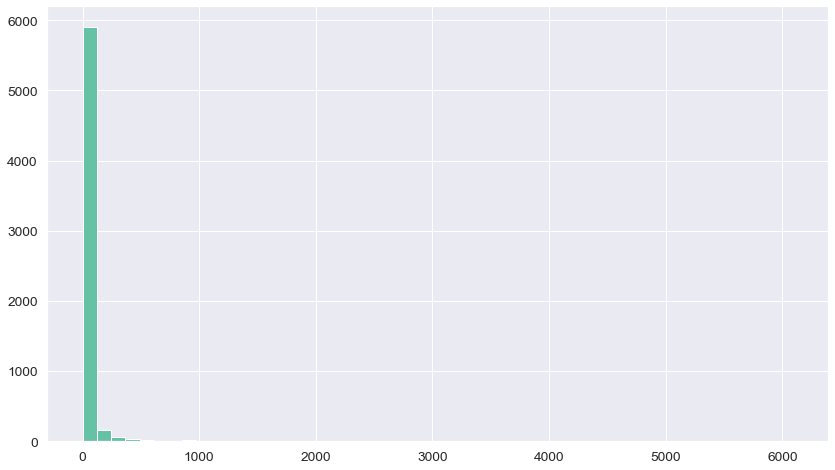

In [22]:
data_train['Ratings'].apply(lambda x: int(x.split()[0].replace(',', ''))).hist(bins=50);

There are some books with 6000 user ratings but mostly not so many.

### Synopsis

We can explore the distribution of Synopsis length

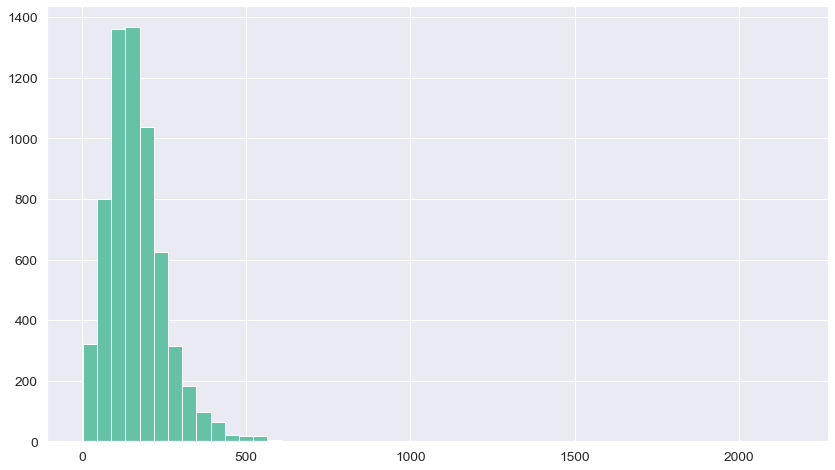

In [23]:
data_train['Synopsis'].apply(lambda x: len(x.split())).hist(bins=50);

For bettter result Synopsis should be processed by one of the feature extraction processes such as tfidf.

### Genre

In [24]:
data_train['Genre'].value_counts()

Action & Adventure (Books)               947
Romance (Books)                          419
Biographies & Autobiographies (Books)    373
Crime, Thriller & Mystery (Books)        276
Contemporary Fiction (Books)             256
                                        ... 
Sign Language Reference                    1
Target Shooting (Books)                    1
Ecotourism                                 1
Internal Medicine                          1
Air Sports (Books)                         1
Name: Genre, Length: 345, dtype: int64

In [25]:
data_test['Genre'].value_counts()

Action & Adventure (Books)               236
Romance (Books)                           98
Biographies & Autobiographies (Books)     90
Contemporary Fiction (Books)              69
Crime, Thriller & Mystery (Books)         59
                                        ... 
International Entrance Exams               1
Functional Software Programming            1
Children's Crime & Thriller (Books)        1
Software Architecture                      1
United States History                      1
Name: Genre, Length: 225, dtype: int64

345 different genres in the training set and 225 in the test set

In [26]:
genres = Counter(data_train['Genre'])

In [27]:
genres.update(data_test['Genre'])

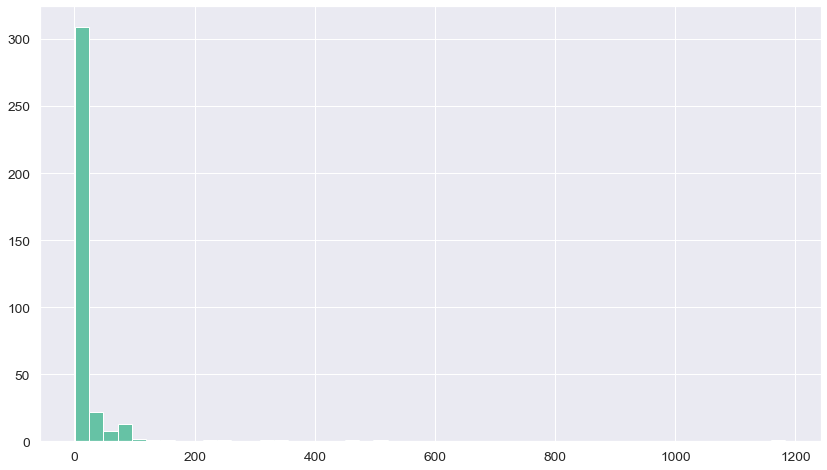

In [28]:
pd.Series(genres.values()).hist(bins=50);

In [29]:
data_train[data_train['Genre'].str.contains(r'\(Books\)')]['Genre'].apply(lambda x: x.split()[-1]).value_counts()

(Books)    4802
Name: Genre, dtype: int64

It seems there are some genres which are not books (magazines or some aother media).

### BookCategory

In [30]:
data_train['BookCategory'].unique()

array(['Action & Adventure', 'Biographies, Diaries & True Accounts',
       'Humour', 'Crime, Thriller & Mystery', 'Arts, Film & Photography',
       'Sports', 'Language, Linguistics & Writing',
       'Computing, Internet & Digital Media', 'Romance',
       'Comics & Mangas', 'Politics'], dtype=object)

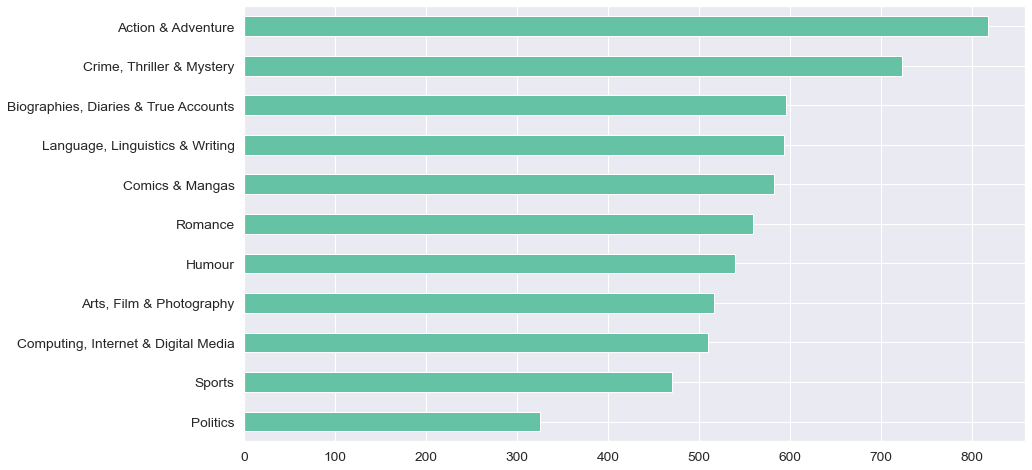

In [31]:
data_train['BookCategory'].value_counts(ascending=True).plot(kind='barh');

### Price

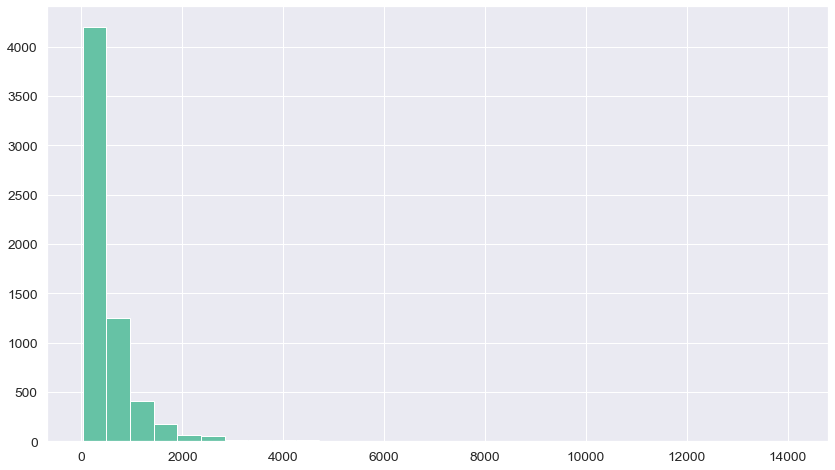

In [32]:
data_train['Price'].hist(bins=30);

Price has likely a log normal distribution. So it'll be better to use target transformer to avoid negative values of price in predictions.

## Feature processing

### Numerical Features

Here we'll extract and process features.
  - Add a Year column (extract Year from Edition column)
  - Add an indicator of missing year value
  - Extracting float number from Reviews
  - Extracting integer number from Ratings
  - Count words in Synopsis 
  - Count words in Title 
  - Count author "popularity"
  - Count genre "popularity"
  - add indicator is import from Edition column
  - add indicator is paperback from Edition column
  - add indicator is nocoverinfo from Edition column
  - add indicator is massmarket from Edition column
  - add indicator is illustrated from Edition column
  - add indicator is book from Genre colum
  

In [33]:
def feature_processing(data):
    def nocoverinfo(column):
        if ('Hardcover' not in column) and ('Softcover' not in column) and ('Paperback' not in column):
            return 1
        else:
            return 0
    # Finding median value of release year
    median_year = (data[data['Edition'].str.contains('\d{4}')]['Edition']
                   .apply(lambda x: re.search('\d{4}', x).group()).median())
    
    # Numeric transform
    data['Year_missed'] = data['Edition'].apply(lambda x: 0 if (x:=re.findall(r'\d{4}', x)) else 1)
    data['Year'] = data['Edition'].apply(lambda x: int(x[0]) if (x:=re.findall(r'\d{4}', x)) else median_year)
    data['Reviews'] = data['Reviews'].apply(lambda x: float(x.split()[0]))
    data['Ratings'] = data['Ratings'].apply(lambda x: int(x.split()[0].replace(',', '')))
    
    # Len features
    data['Synopsis_len'] = data['Synopsis'].apply(lambda x: len(x.split()))
    data['Title_len'] = data['Title'].apply(lambda x: np.log(len(x.split())))
    data['Author_popularity'] = data['Author'].map(authors_rate)
    data['Genre_popularity'] = data['Genre'].map(genres)
                                            
    # Bool features
    data['is_import'] = data['Edition'].apply(lambda x: 'Import' in x)
    data['is_nocoverinfo'] = data['Edition'].apply(nocoverinfo)
    data['is_paperback'] = data['Edition'].apply(lambda x: 'Paperback' in x or 'Softcover' in x)
    data['is_massmarket'] = data['Edition'].apply(lambda x: 'Mass' in x)
    data['is_illustrated'] = data['Edition'].apply(lambda x: 'Illustrated' in x)
    data['is_book'] = data['Genre'].str.contains(r'\(Books\)')


In [34]:
feature_processing(data_train)

In [35]:
feature_processing(data_test)

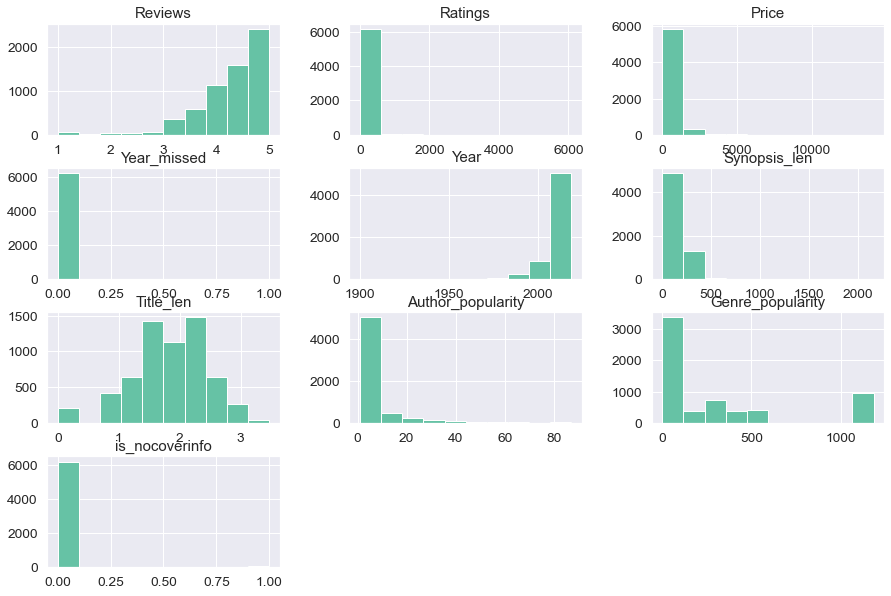

In [36]:
data_train.hist(figsize=(15,10));

### Correlation exploring

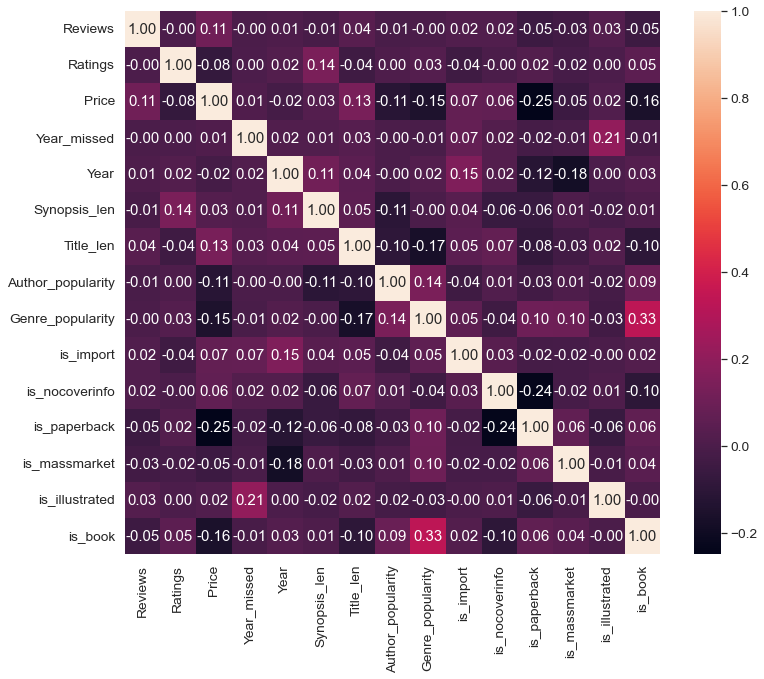

In [37]:
plt.subplots(figsize=(12,10))

sns.heatmap(data_train.corr(), annot=True, fmt='.2f');

There is no multicollinearity in features

### Text features

Clearing text features and lemmatizing then.

In [38]:
def cleaning(text):
    text = str(text)
    text = re.sub(r'[^\w\s]','', text).lower().strip()
    text = re.split('\W+', text)
    return text

In [39]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [40]:
def lemmatizer(text):
    text = ' '.join(text)
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [41]:
for col in ['Title', 'Synopsis', 'Genre', 'BookCategory', 'Edition']:
    data_train[col] = data_train[col].apply(cleaning)
    data_train[col] = data_train[col].progress_apply(lemmatizer)

  0%|          | 0/6237 [00:00<?, ?it/s]

  0%|          | 0/6237 [00:00<?, ?it/s]

  0%|          | 0/6237 [00:00<?, ?it/s]

  0%|          | 0/6237 [00:00<?, ?it/s]

  0%|          | 0/6237 [00:00<?, ?it/s]

In [42]:
for col in ['Title', 'Synopsis', 'Genre', 'BookCategory', 'Edition']:
    data_test[col] = data_test[col].apply(cleaning)
    data_test[col] = data_test[col].progress_apply(lemmatizer)

  0%|          | 0/1560 [00:00<?, ?it/s]

  0%|          | 0/1560 [00:00<?, ?it/s]

  0%|          | 0/1560 [00:00<?, ?it/s]

  0%|          | 0/1560 [00:00<?, ?it/s]

  0%|          | 0/1560 [00:00<?, ?it/s]

### Prepairing training set

Extracting target feature.

In [43]:
X_train = data_train.drop('Price', axis=1)
y_train = data_train['Price']
X_test = data_test.copy()

### Making Scorer

Making an sklearn scorer object to evaluate desired metrics.

In [44]:
def score_func(y_true, y_pred, **kwargs):
    return (1 - np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean()))

In [45]:
scorer = make_scorer(score_func)

## Training models

In [46]:
X_train.columns

Index(['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
       'BookCategory', 'Year_missed', 'Year', 'Synopsis_len', 'Title_len',
       'Author_popularity', 'Genre_popularity', 'is_import', 'is_nocoverinfo',
       'is_paperback', 'is_massmarket', 'is_illustrated', 'is_book'],
      dtype='object')

In [47]:
def model_learning_cv(estimator, features, target, params):
    # Features types    
    text_features = ['Title', 'Author', 'Synopsis', 'Genre', 'BookCategory']
    numeric_features = ['Reviews', 'Ratings', 'Year', 'Synopsis_len', 
                        'Author_popularity', 'Genre_popularity', 'Title_len']
    other_features = ['is_import', 'is_paperback', 'is_massmarket', 'is_illustrated', 
                      'is_book', 'Year_missed', 'is_nocoverinfo']
    
    # Feature transformers
    numeric_transformer = Pipeline([
        ('qt', QuantileTransformer(n_quantiles=1000, output_distribution='normal')),
        ('scaler', StandardScaler()),
        ('pca', PCA())
    ])
    
    text_transformer = Pipeline([
        ("tfidf", HashingVectorizer(strip_accents='ascii'))
         ])
    
    
    ct = ColumnTransformer([
         ("title_preprocess", text_transformer, 'Title'),
         ("author_preprocess", text_transformer, 'Author'),
         ("syn_preprocess", TfidfVectorizer(), 'Synopsis'),
         ("genre_preprocess", text_transformer, 'Genre'),
         ("cat_preprocess", text_transformer, 'BookCategory'),
         ("num_preprocess", numeric_transformer, numeric_features),
         ('pass', 'passthrough', other_features)
                        ])
    
    
    regr = TransformedTargetRegressor(regressor=estimator, 
                                      transformer=QuantileTransformer(
                                          n_quantiles=1000, 
                                          output_distribution='normal'))
    
    pipe = Pipeline([
        ('ftr_trans', ct),
        ('est', regr)
                    ])
        
    gs = GridSearchCV(pipe, param_grid=params, cv=5, scoring=scorer, n_jobs=-1)
    gs.fit(features, target)
    
    
    return gs

### Ridge Regression

In [48]:
params_lr = {'est__regressor__alpha': [0.1, 1, 10]}

In [49]:
gs_lr = model_learning_cv(Ridge(), X_train, y_train, params_lr)

In [50]:
gs_lr.best_params_

{'est__regressor__alpha': 1}

In [51]:
gs_lr.best_score_

0.7794777000673239

### Support Vector Machine Regressor

In [52]:
params_svr = {'est__regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [53]:
gs_svr = model_learning_cv(SVR(), X_train, y_train, params_svr)

In [54]:
gs_svr.best_params_

{'est__regressor__C': 10}

In [55]:
gs_svr.best_score_

0.7806700816405799

### Voting Regressor

In [56]:
vote = VotingRegressor(estimators=[
    ('Linear_Reg', gs_lr.best_estimator_),
    ('Svm_Reg', gs_svr.best_estimator_)], weights=[1,3])

In [57]:
vote.fit(X_train, y_train)

VotingRegressor(estimators=[('Linear_Reg',
                             Pipeline(steps=[('ftr_trans',
                                              ColumnTransformer(transformers=[('title_preprocess',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                HashingVectorizer(strip_accents='ascii'))]),
                                                                               'Title'),
                                                                              ('author_preprocess',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                HashingVectorizer(strip_accents='ascii'))]),
                                                                               'Author'),
                                                                              ('syn_preprocess',
                                                                               TfidfVectorizer(),
                                                                               'Synopsis'),
                                                                              (...
                                                                                'Ratings',
                                                                                'Year',
                                                                                'Synopsis_len',
                                                                                'Author_popularity',
                                                                                'Genre_popularity',
                                                                                'Title_len']),
                                                                              ('pass',
                                                                               'passthrough',
                                                                               ['is_import',
                                                                                'is_paperback',
                                                                                'is_massmarket',
                                                                                'is_illustrated',
                                                                                'is_book',
                                                                                'Year_missed',
                                                                                'is_nocoverinfo'])])),
                                             ('est',
                                              TransformedTargetRegressor(regressor=SVR(C=10),
                                                                         transformer=QuantileTransformer(output_distribution='normal')))]))],
                weights=[1, 3])

In [58]:
sample_submission['Price'] = vote.predict(X_test).round(2)

## Saving Submission Dataset

In [59]:
sample_submission.to_csv('submission.csv', index=None)

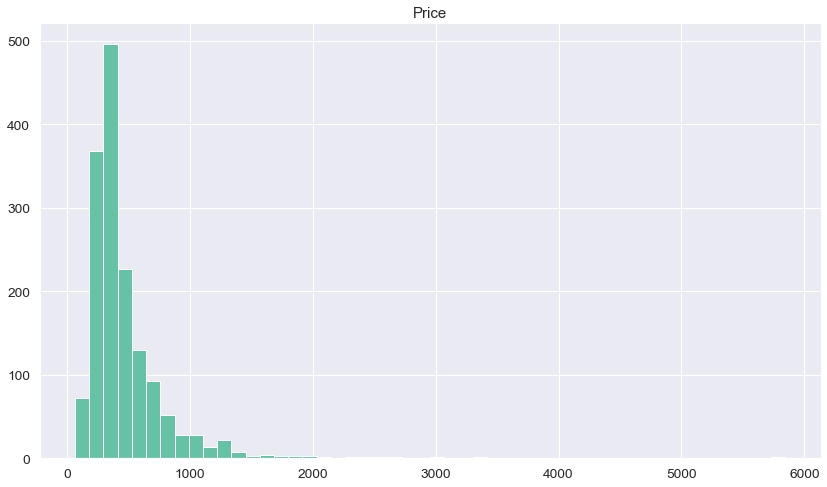

In [60]:
sample_submission.hist(bins=50);

## Conclusion

This approach allowed to get the 22nd place out of more than 5000 participants with final score about **0.789** on quite simple ML model. The key point is feature engineering and feature processing.  

There are some features was directly used or simply extracted from columns:
  - Year
  - Year missing value indicator
  - Review score
  - Number of user ratings  
  
Then some features were calculated:
  - Synopsis length
  - Book title length
  - Author rate
  - Genre rate  
  
Also some specific indicators were extracted from Edition column:
  - is import
  - is no cover info
  - is paperback
  - is massmarket
  - is illustrated
  - is book

All the numeric features were processed through QuantileTransformer as well as target column.

The text features were vectorized through tfidf and hashing vectorizers.

Two linear model were used - Ridge Regression and Support Vector Machines Regressor. After tuning the hyperparameters the models were passed into voting regressor. It improved the result a little bit more.